This code is written by Kuba Jerzmanowski
This code is inspired and based on strongly from Andrej Karpathy Micro Grad Video

In [50]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [51]:
class Scalar:
    def __init__(self, data, _children=(), _op=''): 
        self.data = data
        self.grad = 0
        self.op = _op
        self._backward = lambda: None
        self._prev = set(_children)
    
    def __repr__(self):
        return f'Scalar(data={self.data}, grad={self.grad})'
    
    def __add__(self, other):  #define add and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other) #this helps so we can pass in raw numbers
        out = Scalar(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): #so the sum() works
        return self + other
    
    def __mul__(self, other): #define multiplication and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rmul__(self, other):
        return self * other
    

    def __pow__(self, other):
        out = Scalar(self.data ** other, (self, ), f'^{other}')

        def _backward():
            self.grad += out.grad * (other * (self.data**(other-1)))
        out._backward = _backward
        return out
 
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data) + 1)
        out = Scalar(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Scalar(0 if self.data < 0 else self.data, (self,), 'relu')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    

    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Scalar(s, (self,), 'sigmoid')

        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward

        return out
    
    def backprop(self): #we first build up the topo list then reverse it since we backprop in reverse starting with the Scalar representing the Loss
        self.grad = 1

        chain = []
        seen = set()
        def build_list(node):
            if node not in seen:
                seen.add(node)
                for par in node._prev:
                    build_list(par)
                chain.append(node)

        build_list(self)
        for node in reversed(chain):
            node._backward()


Define the NN 

In [52]:


class Neuron:
    def __init__(self, width, last=False):
        #each neuron has weights to where they are the input width and an additional bias
        self.w = [Scalar(random.uniform(-1,1)) for _ in range(width)]
        self.b = Scalar(0)
        self.last = last

    def __call__(self, x):
        #here we want to miltiply so we will zip the weights to do wx+b
        out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        if self.last:
            return out
        return out.relu()
    
    def params(self): #this function is nesscary so that we can later update each param after getting the grad
        return self.w + [self.b]
    
class Layer: #here we just move up another layer of abstraction where we will 
    def __init__(self, num_in, num_out, last=False):
        self.last = last
        self.neurons = [Neuron(num_in, last) for _ in range(num_out)]

    def __call__(self, x):
        out =  [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    
    def params(self):
        params = []
        for n in self.neurons:
            p = n.params()
            params.extend(p)
        return params
    
class MLP: 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [
            Layer(sz[i], sz[i+1], last=(i == len(nouts) - 1)) #thsis jsut so that the last layer does not have a actiation funtion
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        params = []
        for l in self.layers:
            p = l.params()
            params.extend(p)
        return params
    
    def zero_grad(self):
        params = self.params()
        for p in params:
            p.grad = 0
    



Define the loss function. We have to double unpack because y is 2 outputs

Def the Data

In [53]:
X = [
    [-1.0],
    [-0.9],
    [-0.8],
    [-0.7],
    [-0.6],
    [-0.5],
    [-0.4],
    [-0.3],
    [-0.2],
    [-0.1],
    [0],
    [0.1],
    [0.2],
    [0.3],
    [0.4],
    [0.5],
    [0.6],
    [0.7],
    [0.8],
    [0.9],
    [1.0]
]

Y = [
    [-0.96],
    [-0.577],
    [-0.073],
    [0.377],
    [0.641],
    [0.66],
    [0.461],
    [0.134],
    [-0.201],
    [-0.434],
    [-0.5],
    [-0.393],
    [-0.165],
    [0.099],
    [0.307],
    [0.396],
    [0.345],
    [0.182],
    [-0.031],
    [-0.219],
    [-0.321]
]

nn = MLP(1, [64,32,1])
lossi = [] #accumulate the loss

In [54]:
def loss():
    
    outs = [nn(x) for x in X]
    # MSE loss

    losses = []
    for out, ytrue in zip(outs, Y):
        losses.append((out - ytrue[0]) * (out - ytrue[0]))

    data_loss = sum(losses) * (1.0 / len(losses))
    
    return data_loss

Train Looop

epoch:0 loss:2.3701401702954303
epoch:1 loss:0.41305904397069315
epoch:2 loss:0.28065917914483
epoch:3 loss:0.2568009821654102
epoch:4 loss:0.24330233794964568
epoch:5 loss:0.22981129977139836
epoch:6 loss:0.21669672882163227
epoch:7 loss:0.2021560220346732
epoch:8 loss:0.19045408062875846
epoch:9 loss:0.1850834861301684
epoch:10 loss:0.17915029933817458


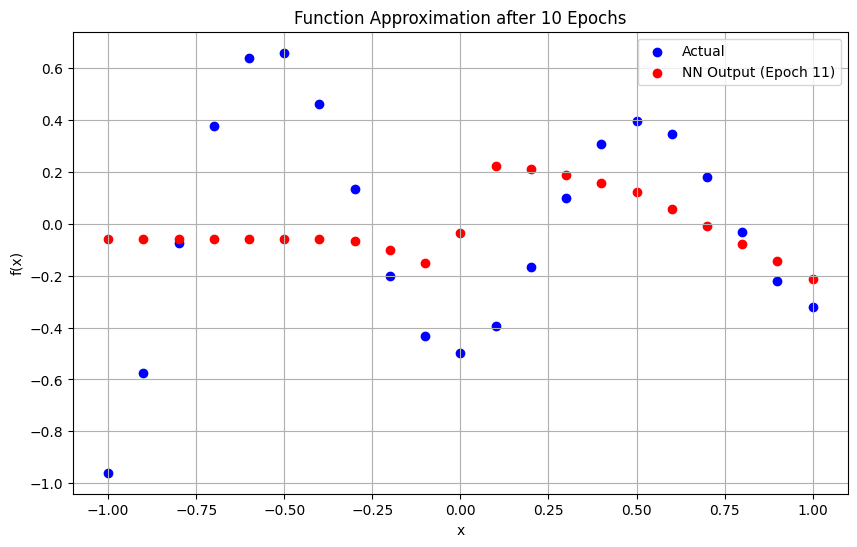

epoch:11 loss:0.1740922195181161
epoch:12 loss:0.16997149158873437
epoch:13 loss:0.16650326563727003
epoch:14 loss:0.16349595617895693
epoch:15 loss:0.1610876412051047
epoch:16 loss:0.15900414657440137
epoch:17 loss:0.15697353782573248
epoch:18 loss:0.15507695243822603
epoch:19 loss:0.1533789863746339
epoch:20 loss:0.15183456960398245


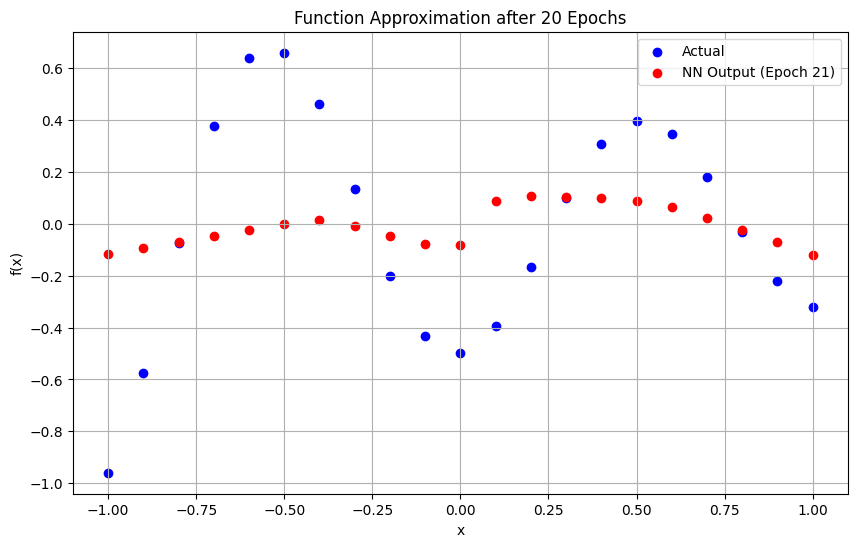

epoch:21 loss:0.15035057965155632
epoch:22 loss:0.14902791886179284
epoch:23 loss:0.1478672164550747
epoch:24 loss:0.1466913746842065
epoch:25 loss:0.1456592767359327
epoch:26 loss:0.14460795227061932
epoch:27 loss:0.1435732369469615
epoch:28 loss:0.14262895418379462
epoch:29 loss:0.1416692152727124
epoch:30 loss:0.14118258073236944
epoch:31 loss:0.14071560404103672
epoch:32 loss:0.13943951269009638
epoch:33 loss:0.13864864969417698
epoch:34 loss:0.137859192573695
epoch:35 loss:0.13718740833697246
epoch:36 loss:0.13649515357380398
epoch:37 loss:0.13581377560963612
epoch:38 loss:0.13520329258738398
epoch:39 loss:0.1345332028343017
epoch:40 loss:0.13389964510524582
epoch:41 loss:0.1333226545511982
epoch:42 loss:0.1327071822128322
epoch:43 loss:0.13216309587954383
epoch:44 loss:0.13156318186051288
epoch:45 loss:0.13098841738985756
epoch:46 loss:0.13027759699189326
epoch:47 loss:0.12954726618151702
epoch:48 loss:0.1288562855714452
epoch:49 loss:0.1281520058826489
epoch:50 loss:0.1273863792

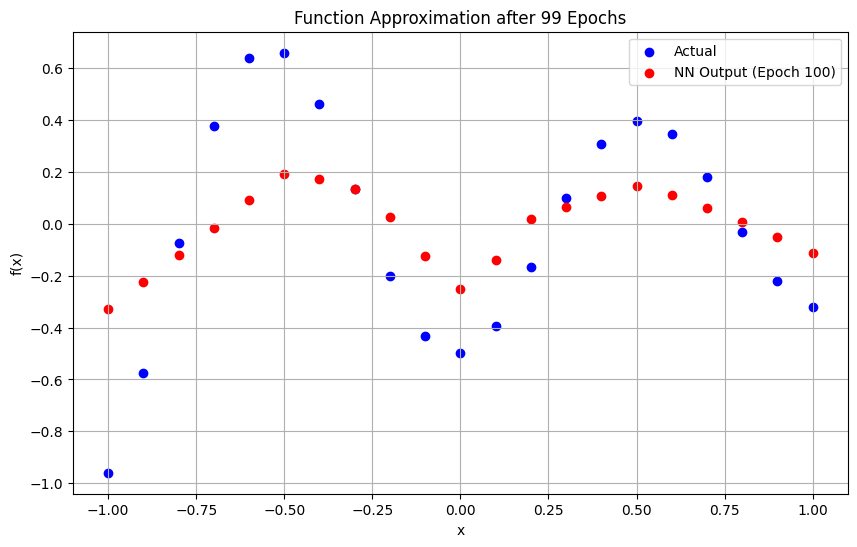

epoch:100 loss:0.0872709459856229
epoch:101 loss:0.08654953811661086
epoch:102 loss:0.08572881851480112
epoch:103 loss:0.08496132470869869
epoch:104 loss:0.08420505383350606
epoch:105 loss:0.08339565367929394
epoch:106 loss:0.08266053541139769
epoch:107 loss:0.08186721361808434
epoch:108 loss:0.08118893402578183
epoch:109 loss:0.08040138846404447
epoch:110 loss:0.07973747112752072
epoch:111 loss:0.07900214002645072
epoch:112 loss:0.07831912492203541
epoch:113 loss:0.077673708405964
epoch:114 loss:0.07703199257661172
epoch:115 loss:0.07645518765774004
epoch:116 loss:0.07577729558027912
epoch:117 loss:0.0751429212112257
epoch:118 loss:0.07435646604417775
epoch:119 loss:0.0737640659766201
epoch:120 loss:0.07302046255079855
epoch:121 loss:0.07237960410463393
epoch:122 loss:0.07168528733486267
epoch:123 loss:0.0710189945160565
epoch:124 loss:0.07039933244894328
epoch:125 loss:0.06968769682761528
epoch:126 loss:0.06912969070712764
epoch:127 loss:0.06844757774457316
epoch:128 loss:0.067876180

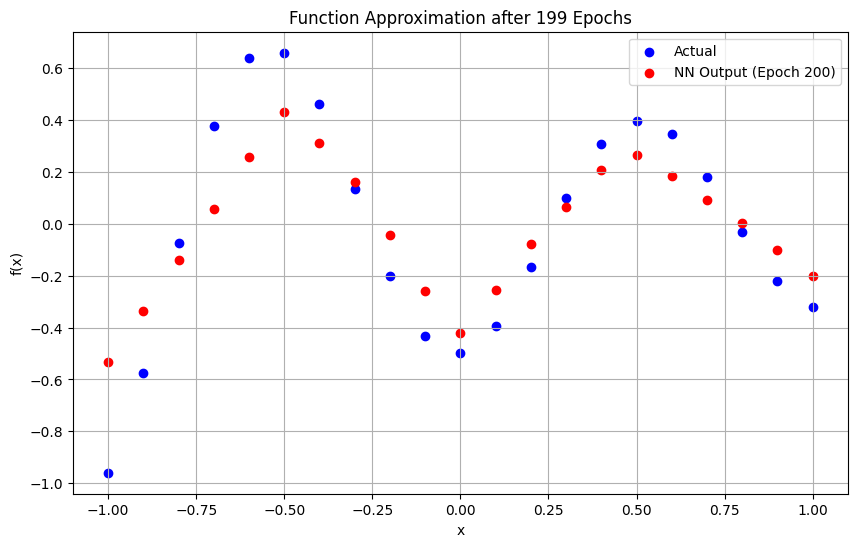

epoch:200 loss:0.035614715167735164
epoch:201 loss:0.03529224477266138
epoch:202 loss:0.03499925397181636
epoch:203 loss:0.034679509135930355
epoch:204 loss:0.03437222150904577
epoch:205 loss:0.03409400645725609
epoch:206 loss:0.033785652570205986
epoch:207 loss:0.0334866572670871
epoch:208 loss:0.03320467643381251
epoch:209 loss:0.03292075652297236
epoch:210 loss:0.032625409022904325
epoch:211 loss:0.032345798590707575
epoch:212 loss:0.03208453183643132
epoch:213 loss:0.03179656974833141
epoch:214 loss:0.031520962353859316
epoch:215 loss:0.031249119997908806
epoch:216 loss:0.030993606333593635
epoch:217 loss:0.03072501280173248
epoch:218 loss:0.03046274689185609
epoch:219 loss:0.030204055551266658
epoch:220 loss:0.029948359391146314
epoch:221 loss:0.029707115247552582
epoch:222 loss:0.029450808565762557
epoch:223 loss:0.02920269494567066
epoch:224 loss:0.02897342067554896
epoch:225 loss:0.02876349068726378
epoch:226 loss:0.028561744041607637
epoch:227 loss:0.028362998041486953
epoch:2

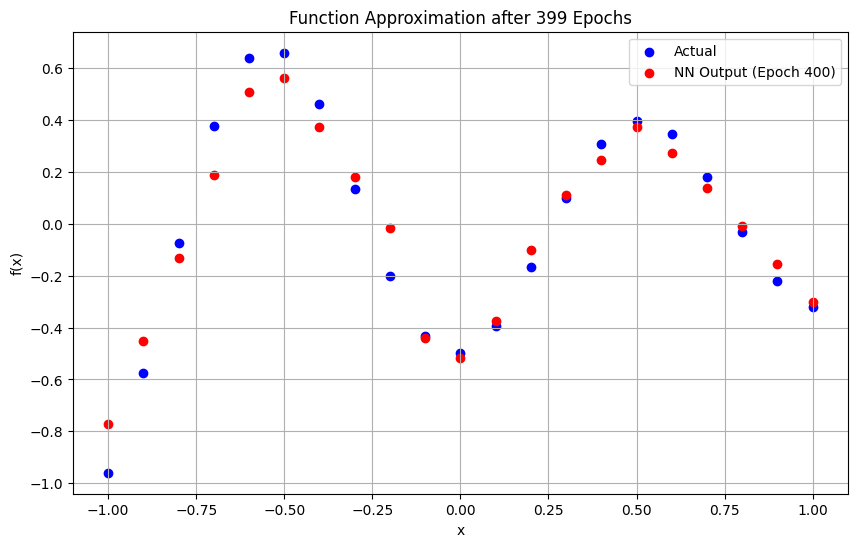

epoch:400 loss:0.008601396811883245
epoch:401 loss:0.008564918039767631
epoch:402 loss:0.008525713685317475
epoch:403 loss:0.008488403874751384
epoch:404 loss:0.008453091953998803
epoch:405 loss:0.008413562747849311
epoch:406 loss:0.008376288284088693
epoch:407 loss:0.00834319089606539
epoch:408 loss:0.008305549061433371
epoch:409 loss:0.00826881820823995
epoch:410 loss:0.00823543336436724
epoch:411 loss:0.008200708188904443
epoch:412 loss:0.008164529126808035
epoch:413 loss:0.008130572494948708
epoch:414 loss:0.008097469963117367
epoch:415 loss:0.008061783056199286
epoch:416 loss:0.008028321686530934
epoch:417 loss:0.007996384387769258
epoch:418 loss:0.007961205176918259
epoch:419 loss:0.007927568854079468
epoch:420 loss:0.007894721294428293
epoch:421 loss:0.007863586807413243
epoch:422 loss:0.007829348114393567
epoch:423 loss:0.007795981078074712
epoch:424 loss:0.007765905851982163
epoch:425 loss:0.0077335776717635
epoch:426 loss:0.007700968620025647
epoch:427 loss:0.0076693000341105

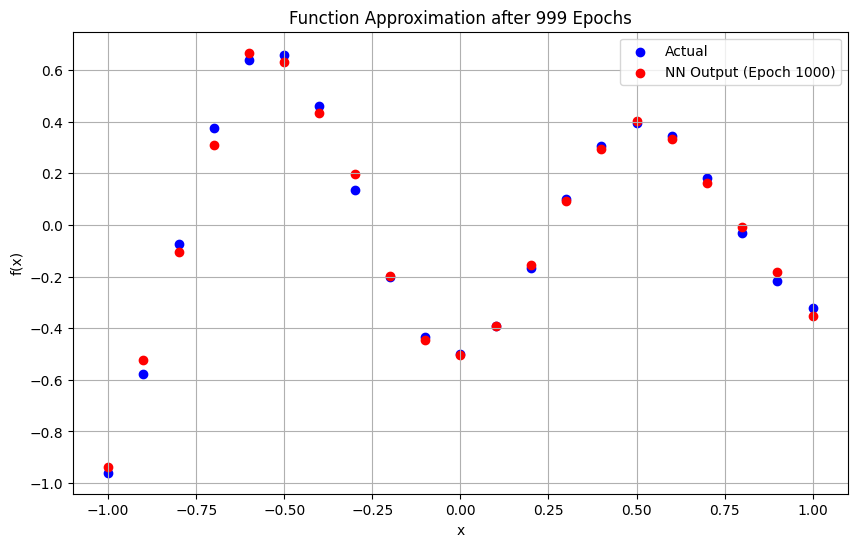

In [55]:
for epoch in range(1000):
    # forward
    total_loss = loss()
    lossi.append(total_loss.data)
    print(f'epoch:{epoch} loss:{total_loss.data}')

    # backward
    nn.zero_grad()
    total_loss.backprop()
    
    # optim step
    learning_rate = 0.01
    for p in nn.params():
        p.data -= learning_rate * p.grad

    if epoch in [10, 20, 99, 199, 399, 999]:
        plt.figure(figsize=(10, 6))
        plt.scatter(X, Y, color='blue', label='Actual')
        
        # X_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
        Y_plot = [nn(x).data for x in X]
        plt.scatter(X, Y_plot, color='red', label=f'NN Output (Epoch {epoch+1})')
        
        plt.title(f'Function Approximation after {epoch} Epochs')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        plt.grid(True)
        plt.show()

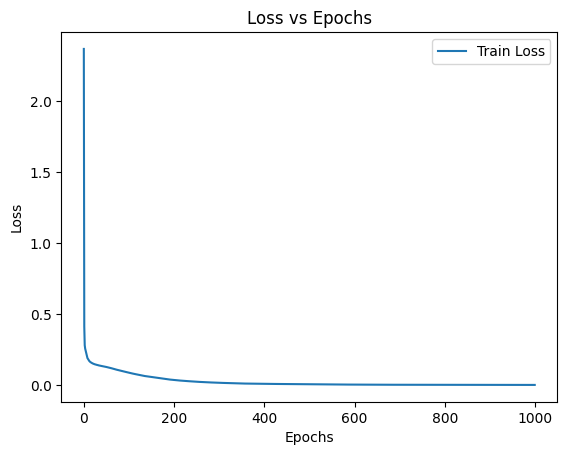

In [56]:
plt.plot(lossi, label='Train Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()